# 0.0. Understanding the problem

--Goal:
    
    --1.0 Predict the first destination that the new user will choose
    
    --Why?
        --What is the business model of Airbnb?
            --Marketplace (connect people who offer acomodation to whom are seeking a place)
            --Offer
                --Portfolio size
                --Portfolio diversity and density
                --Average price
                
            --Demand
                --Number of users
                --LTV (lifetime value)
                --CAC (client acquisition cost)
                
                Gross Revenue = (Fee*Number of clients) - CAC
                
--Solution:
    
    --Predictive model for the first destination of new user
    --1.0 Prediction save in a database
    --2.0 API
        --Input: User and features
        --Output: User and feature with destination prediction
        

# Module 1

## 0.0. Imports

### 0.1. Helper Functions

In [68]:
!pip install keras
!pip install tensorflow
!pip install scikit-plot

In [21]:
import pandas as pd
import random

from sklearn    import metrics         as m
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from scikitplot import metrics         as mt

from keras import models as ml
from keras import layers as l

### 0.2. Loading Data

In [2]:
df_raw = pd.read_csv('dataset/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [3]:
#df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
#df_sessions.shape

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


## 1.1. Data Type

In [6]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.2. NA Check

In [7]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [8]:
#remove missing data
df1 = df1.dropna()
df1.shape

(68171, 16)

## 1.3. Change Data Type

In [9]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

#age
df1['age'] = df1['age'].astype(int)

## 1.4. Change Balanced Data

In [10]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0. 

In [11]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 3.0. Data Preparation

In [12]:
df3 = df2.copy()

In [13]:
#dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id','country_destination'], axis=1))

#join id and country destination
df3 = pd.concat([df3[['id','country_destination']], df3_dummy], axis=1)

# 4.0. Feature Seleciotn

In [14]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df4 = df3.drop(cols_drop, axis=1)

In [ ]:
X = df4.drop(['id', 'country_destination'], axis=1)
y = df4['country_destination'].copy()

In [ ]:
#split dataset into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 5.0. Machine Learning

## 5.1. Baseline Model

In [28]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list, 
                             weights=country_destination_weights,
                             k=k_num)
len(yhat_random)

13635

Accuracy: 0.5167583425009168
Balanced Accuracy: 0.08868331849896349
Kappa Accuracy: 0.0019092824220979798


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

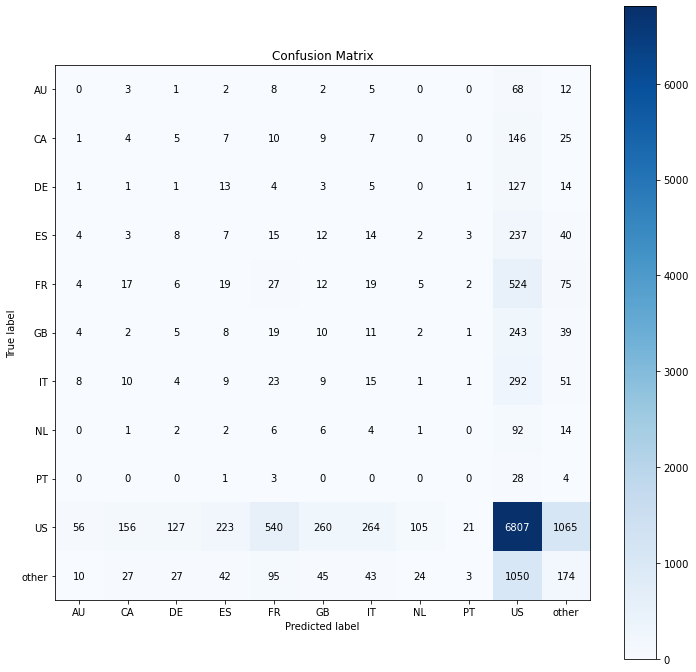

In [29]:
#accuracy
acc_random = m.accuracy_score(y_test_nn, yhat_random)
print('Accuracy: {}'.format(acc_random))

#balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test_nn, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

#Kappa metrics
kappa_random = m.cohen_kappa_score(y_test_nn, yhat_random)
print('Kappa Accuracy: {}'.format(kappa_random))

#confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_random, normalize=False, figsize=(12,12))

## 5.2. Neural Network - MLP

In [17]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [18]:
#model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train_nn, epochs=10)

Epoch 1/10
1705/1705 [==============================] - 6s 1ms/step - loss: 1.6875 - accuracy: 0.6770
Epoch 2/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2864 - accuracy: 0.7045
Epoch 3/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2713 - accuracy: 0.7061
Epoch 4/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2352 - accuracy: 0.7074
Epoch 5/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2013 - accuracy: 0.7093
Epoch 6/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1747 - accuracy: 0.7111
Epoch 7/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1849 - accuracy: 0.7063
Epoch 8/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1590 - accuracy: 0.7086
Epoch 9/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1443 - accuracy: 0.7085
Epoch 10/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.143

# 5.0. NN Performance

In [19]:
#prediction
pred_nn = model.predict(X_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.7058305830583058
Balanced Accuracy: 0.09090909090909091
Kappa Accuracy: 0.0


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

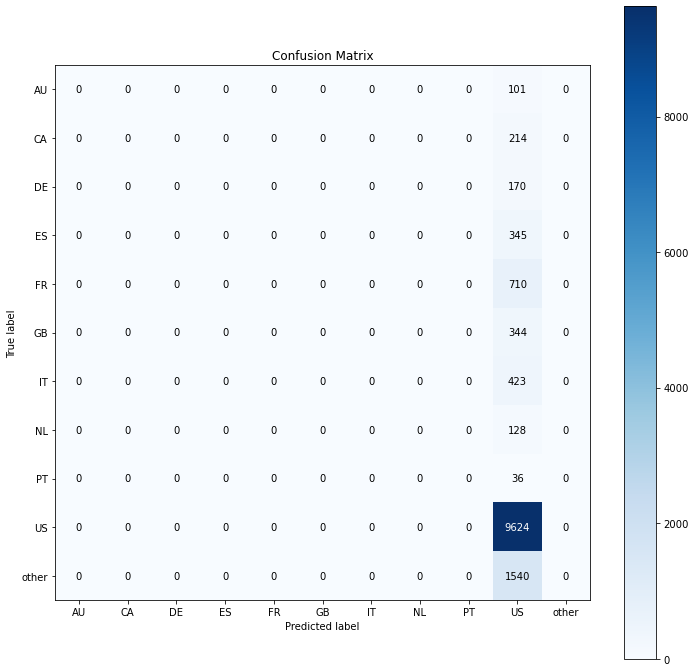

In [20]:
#accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

#Kappa metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Accuracy: {}'.format(kappa_nn))

#confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))